In [ ]:
#########################################################################
# Pruebas con algoritmo de series temporales SARIMA (facilitado por Isma)
# adaptado a nuestro caso
# Se utiliza un dataset que utiliza exclusivamente el indicador 'O3' de 
# la estación de av. de Francia
#########################################################################

# Seasonal AutoRegressive Integrated Moving Averages


Para series temporales con efectos estacionales, utilizamos el ARIMA estacional, que se denomina ARIMA(p,d,q)(P,D,Q)s. Dónde, (p, d, q) son los parámetros no estacionales descritos para ARIMA, mientras que (P, D, Q) siguen la misma definición pero se aplican al componente estacional de la serie temporal. El término s es la periodicidad de la serie temporal (4 para los períodos trimestrales, 12 para los períodos anuales, etc.)

## Carga de la serie temporal mensual de los contenedores movidos por el puerto de Valencia

In [31]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')

# Configuración general de las figuras que representaremos
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 10)

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


              O3
FECHA           
2009-01-01  18.0
2009-01-02  13.0
2009-01-03  10.0
2009-01-04  28.0
2009-01-05  16.0
              O3
FECHA           
2019-12-27  16.0
2019-12-28  17.0
2019-12-29  30.0
2019-12-30  21.0
2019-12-31  14.0


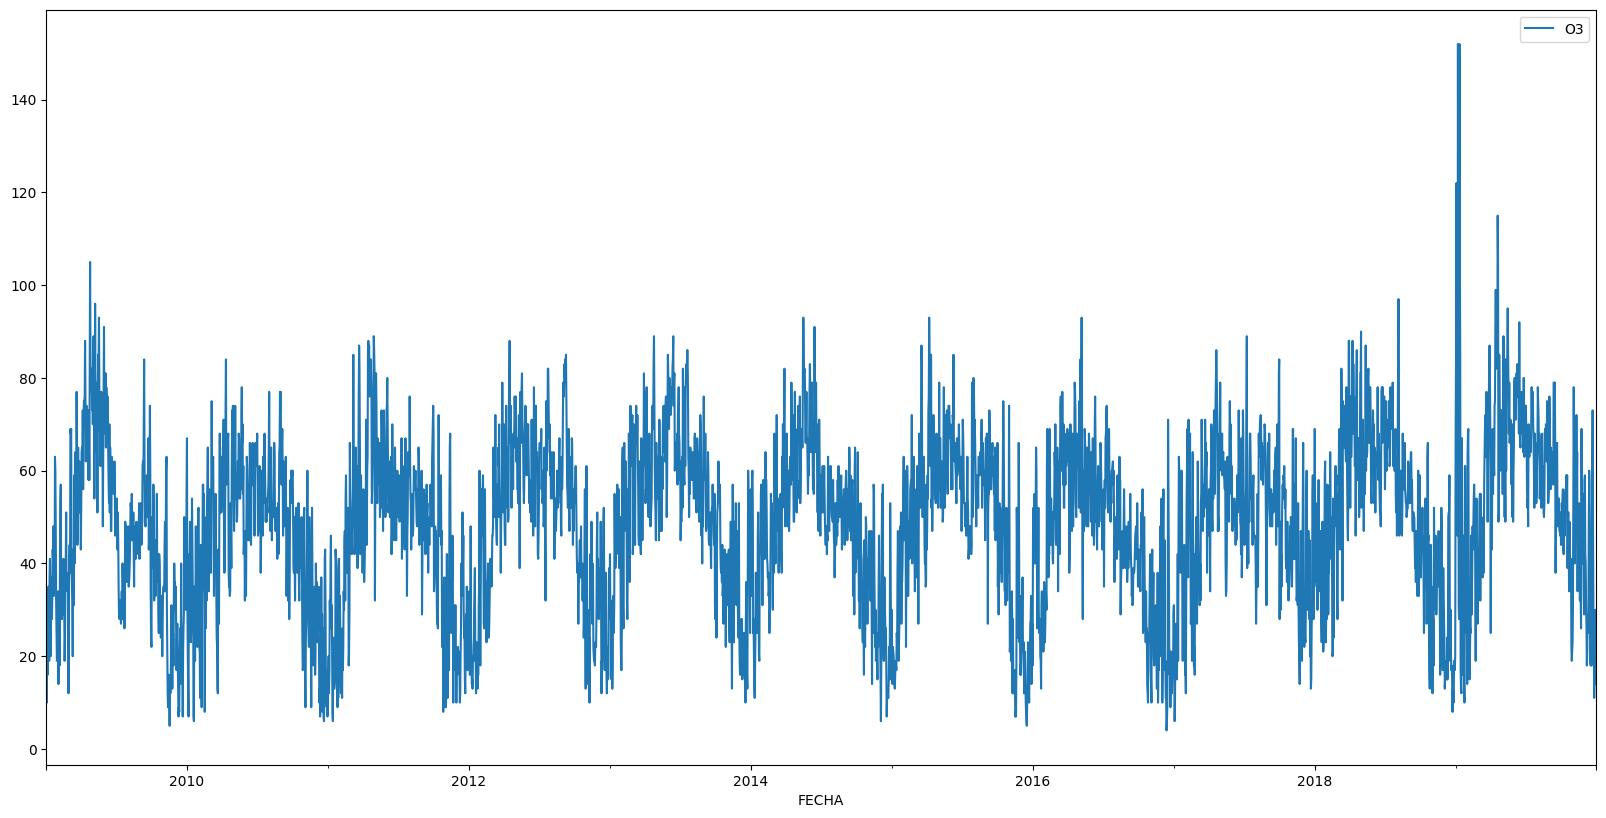

In [33]:
from pandas import read_csv
from datetime import datetime

path = '/content/drive/MyDrive/datoscsv/'
SerieValMen = read_csv(path + 'prueba_sarima.csv',  sep=';', header=0, index_col='FECHA', parse_dates=['FECHA'])

# Solo utilizamos dados hasta final de 2019
SerieValMen = SerieValMen[:'2019']

print(SerieValMen.head())
print(SerieValMen.tail())
SerieValMen.plot()
plt.show()

In [34]:
type(SerieValMen)

pandas.core.frame.DataFrame

In [35]:
# Para que el algoritmo funciones hay que asegurarse que no hay fechas (índices) duplicadas
print('Fechas duplicadas:', SerieValMen[SerieValMen.index.duplicated()])

# Si aparecen fechas duplicadas deben eliminarse del dataset

# Rellenar las posibles fechas faltantes en el dataframe
SerieValMen.asfreq(freq='D').dropna()

SerieValMen

Fechas duplicadas: Empty DataFrame
Columns: [O3]
Index: []


,O3
FECHA,
2009-01-01,18.0
2009-01-02,13.0
2009-01-03,10.0
2009-01-04,28.0
2009-01-05,16.0
...,...
2019-12-27,16.0
2019-12-28,17.0
2019-12-29,30.0


Nota: la serie incluyde datos afectados por la crisis del covid

## Estudio de las características de la serie temporal (tendencia, estacionalidad)

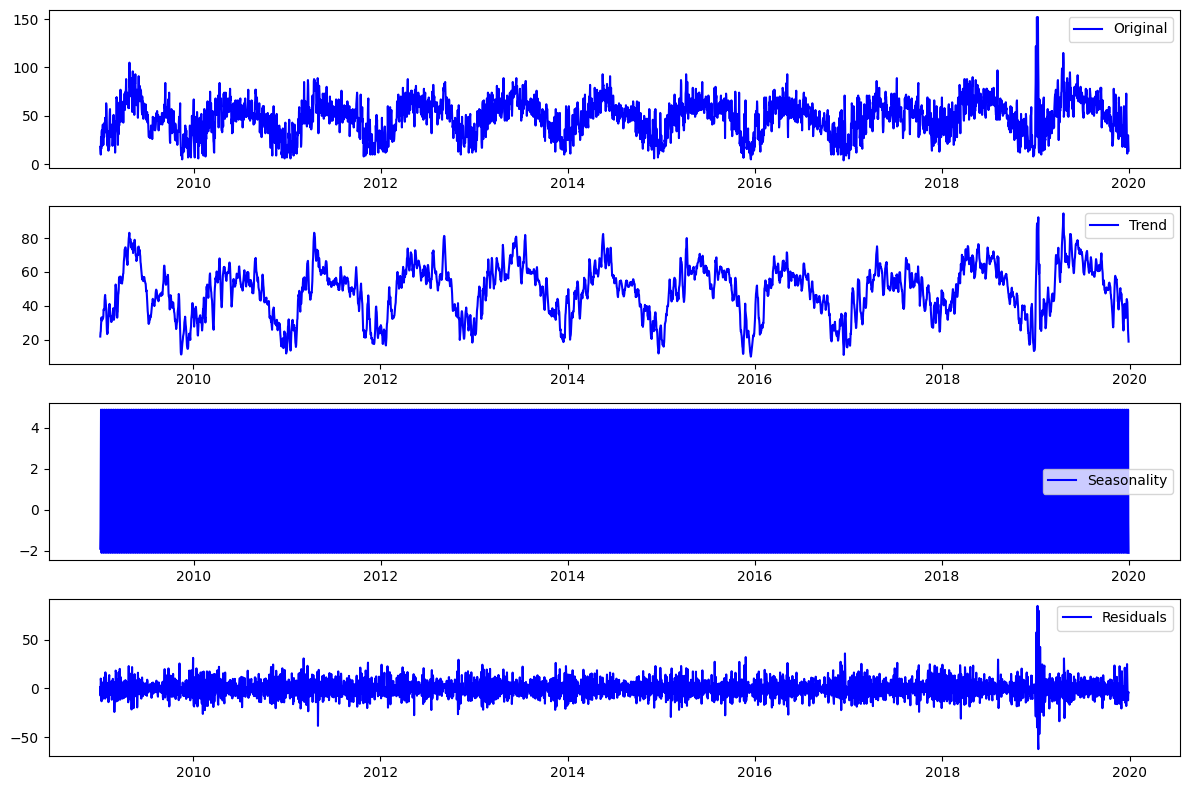

In [36]:
#estacionalidad del modelo 

from statsmodels.tsa.stattools import adfuller
#dftest = adfuller(ts)


from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(SerieValMen, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(SerieValMen, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

se puede observar que hay una tendencia al alza y que hay una estacionalidad anual

## Determinación de los valores de los parámetros más indicados para la serie estudiada

En este caso se determina los valores más apropiados a traves de grid search (hyperparameter optimization), que consiste en probar una combinación de valores y ver cual se ajusta mejor a la serie en cuestion.
Para ello nos quedamos el modelo que de una valor de AIC (Akaike Information Criterion) más bajo

In [37]:
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3 

import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))



Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [38]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_score, best_cfg = float("inf"), None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(SerieValMen,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            mse= results.aic
            if mse < best_score:
                #print ('fff')
                best_score, best_cfg = mse, param  +param_seasonal
                #best_score= mse			
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:43146.99253777606
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:39817.22388253194
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:34642.62597796798
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:33227.84983810871
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:34528.372731862575
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:33317.981273560785
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:33447.52905040454
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:33178.59810210871
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:38882.27594309611
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:36545.67196576987
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:33333.01314627167
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:31682.213293543602
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:33148.86081213053
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:31766.56054785668
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:32123.927357517616
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:31665.859944423933
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:31246.594434906634
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:31132.351805638507
ARI

Ahora ejecutamos el modelo Sarima con los valores más apropiados para nuestra serie y analizamos los resultados.

Los valores que tengan un valor de p>|z| es menor que 0,05, quiere decir que son significativos, en nuestro caso la mayoría de parámetros son significativos (4 de 5).
No obstabte generamos una gráfica de diagnóstico para determinar que el resultado de ajusta a lo que esperabamos.

1) primero hemos de ver que los residuos no están correlacionados y además están distribuidos con media 0 y no sigen una estacionalidad (residual for T) y distribucion parecida a la normal N(0,1)  (Histograma)
2) el grafico Normal Q-Q, muestra que los residuos siguen la tendencia

3) según el correlograma no se aprecia correlacion entre los residuos.

Con estos datos podemos concluir que el modelo tiene un ajuste satisfactorio y nos puede ayudar a entender nuestra serie temporal y predecir valores futuros.


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4913      0.014     36.042      0.000       0.465       0.518
ma.L1         -0.9086      0.006   -144.891      0.000      -0.921      -0.896
ar.S.L12      -0.0786      0.015     -5.412      0.000      -0.107      -0.050
ma.S.L12      -1.0000      0.836     -1.196      0.232      -2.639       0.639
sigma2       113.5580     95.171      1.193      0.233     -72.973     300.089


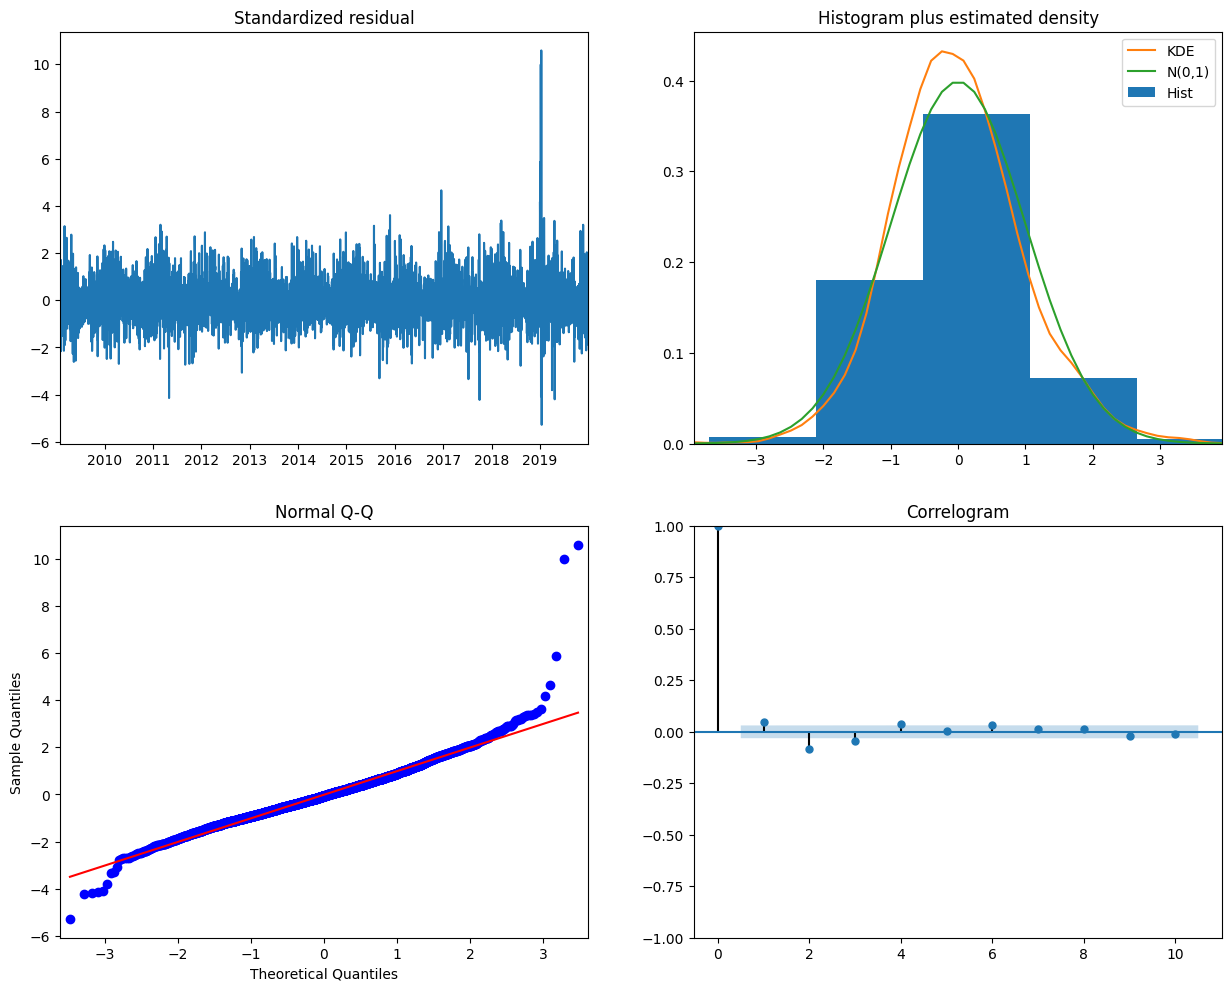

In [39]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(SerieValMen,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Validar predicciones - Serie original (sin comtemplar  datos de 2020)

1) compararemos valores predecidos con valores reales, para ver quan bien funciona el modelo

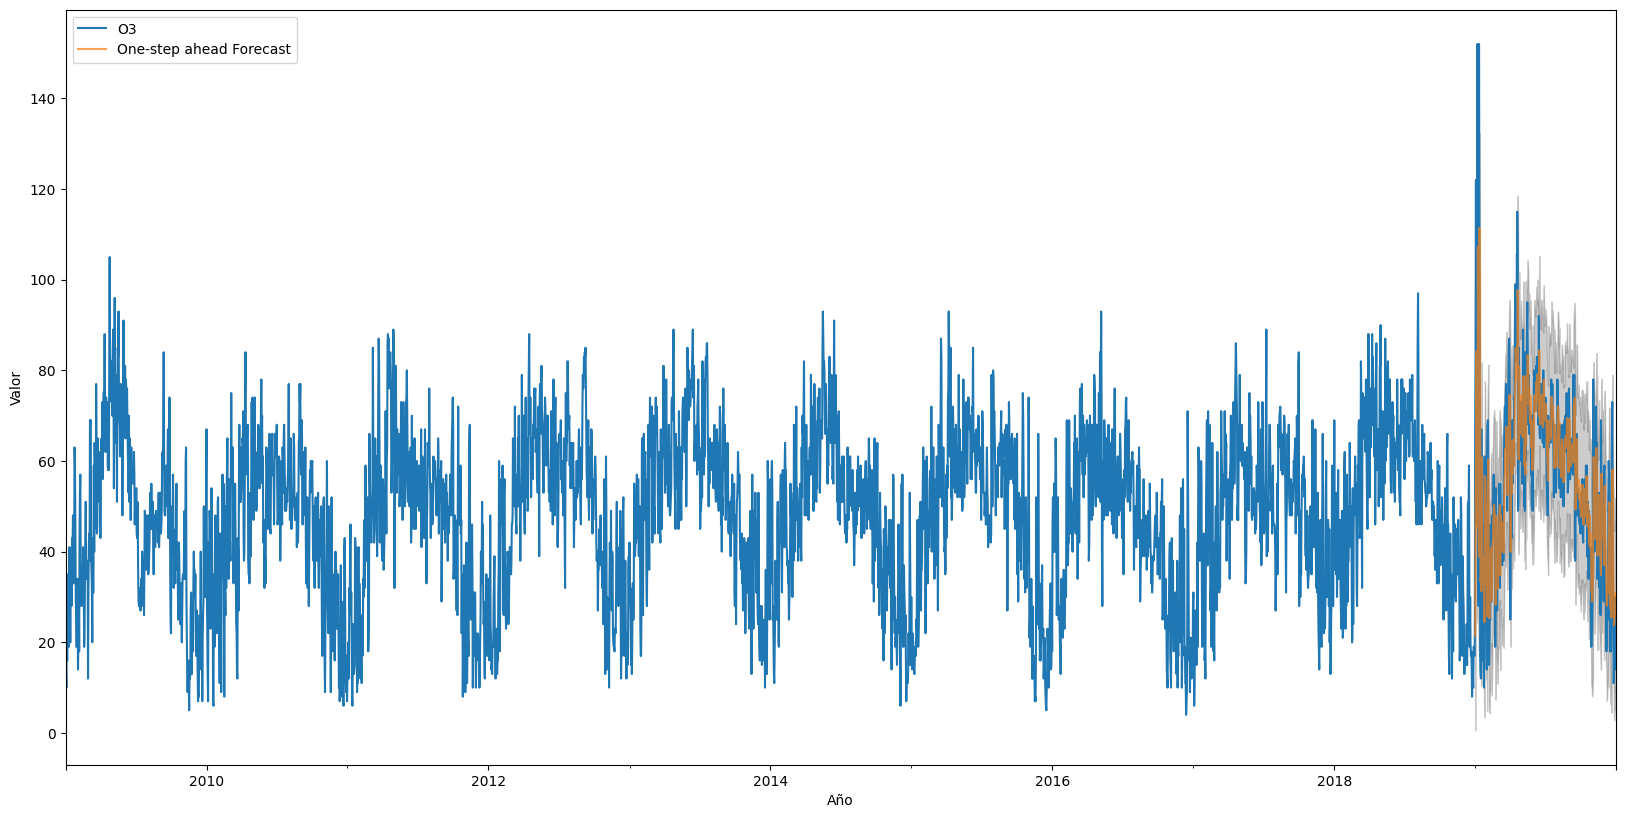

In [40]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = SerieValMen.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Año')
ax.set_ylabel('Valor')
plt.legend()

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

plt.show()


La funcion get_prediction() y conf_int() nos permiten obtener la predicción y los intervalos de confianza para las predicciones

Podemos repetir la predicción en este caso con el parametro dynamic a False para que no considere la serie entera

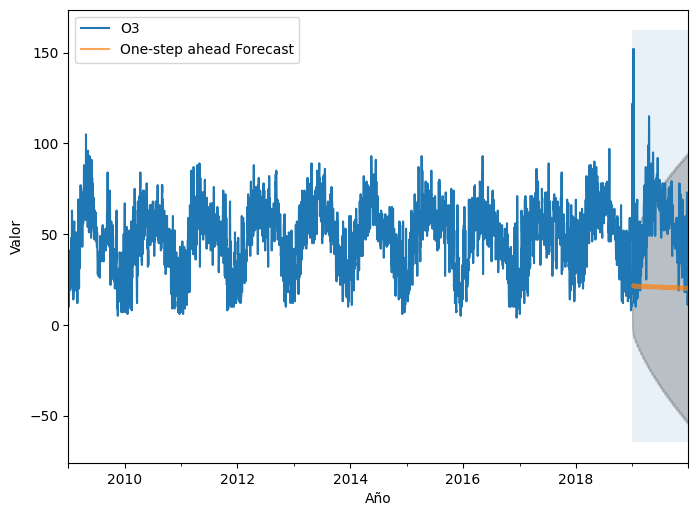

In [41]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), end=pd.to_datetime('2019-12-31'), dynamic=True)
pred_ci = pred.conf_int()
ax = SerieValMen.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-01-01'), SerieValMen.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Año')
ax.set_ylabel('Valor')
plt.legend()
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100
plt.show()

predicted=28.748993, expected=52.000000
predicted=40.461080, expected=48.000000
predicted=44.761587, expected=33.000000
predicted=38.693402, expected=25.000000
predicted=30.562534, expected=17.000000
predicted=22.359433, expected=39.000000
predicted=31.072683, expected=31.000000
predicted=31.607220, expected=28.000000
predicted=30.605857, expected=23.000000
predicted=26.379795, expected=13.000000
predicted=19.342218, expected=16.000000
predicted=16.725736, expected=17.000000
predicted=17.252384, expected=16.000000
predicted=16.478823, expected=19.000000
predicted=18.325943, expected=15.000000
predicted=17.271751, expected=24.000000
predicted=21.144541, expected=15.000000
predicted=16.092948, expected=21.000000
predicted=18.366520, expected=50.000000
predicted=36.307454, expected=51.000000
predicted=45.148072, expected=51.000000
predicted=47.940151, expected=59.000000
predicted=54.328020, expected=28.000000
predicted=39.867413, expected=19.000000
predicted=30.106418, expected=30.000000


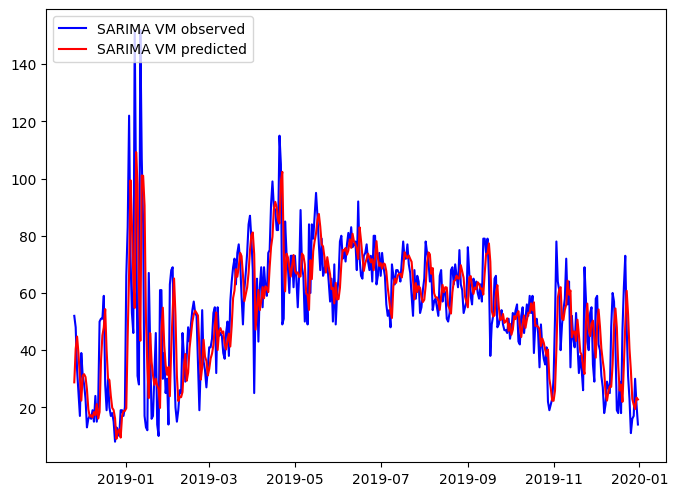

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

# split into train and test sets
X = SerieValMen.values
size = int(len(X) * 0.90)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = sm.tsa.statespace.SARIMAX(history, order=(0, 1, 1),seasonal_order=(1, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print('Test  MAE: %.3f' % mae)

# plot forecasts against actual outcomes
import matplotlib.pyplot as pyplot
pyplot.plot(SerieValMen.index[size:len(X)], test , color='blue',  label="SARIMA VM observed")
pyplot.plot(SerieValMen.index[size:len(X)],predictions, color='red',  label="SARIMA VM predicted")
pyplot.legend(loc="upper left")
pyplot.show()

## Prediccion de valores futuros

para ello usamos la funcion get_forecast()

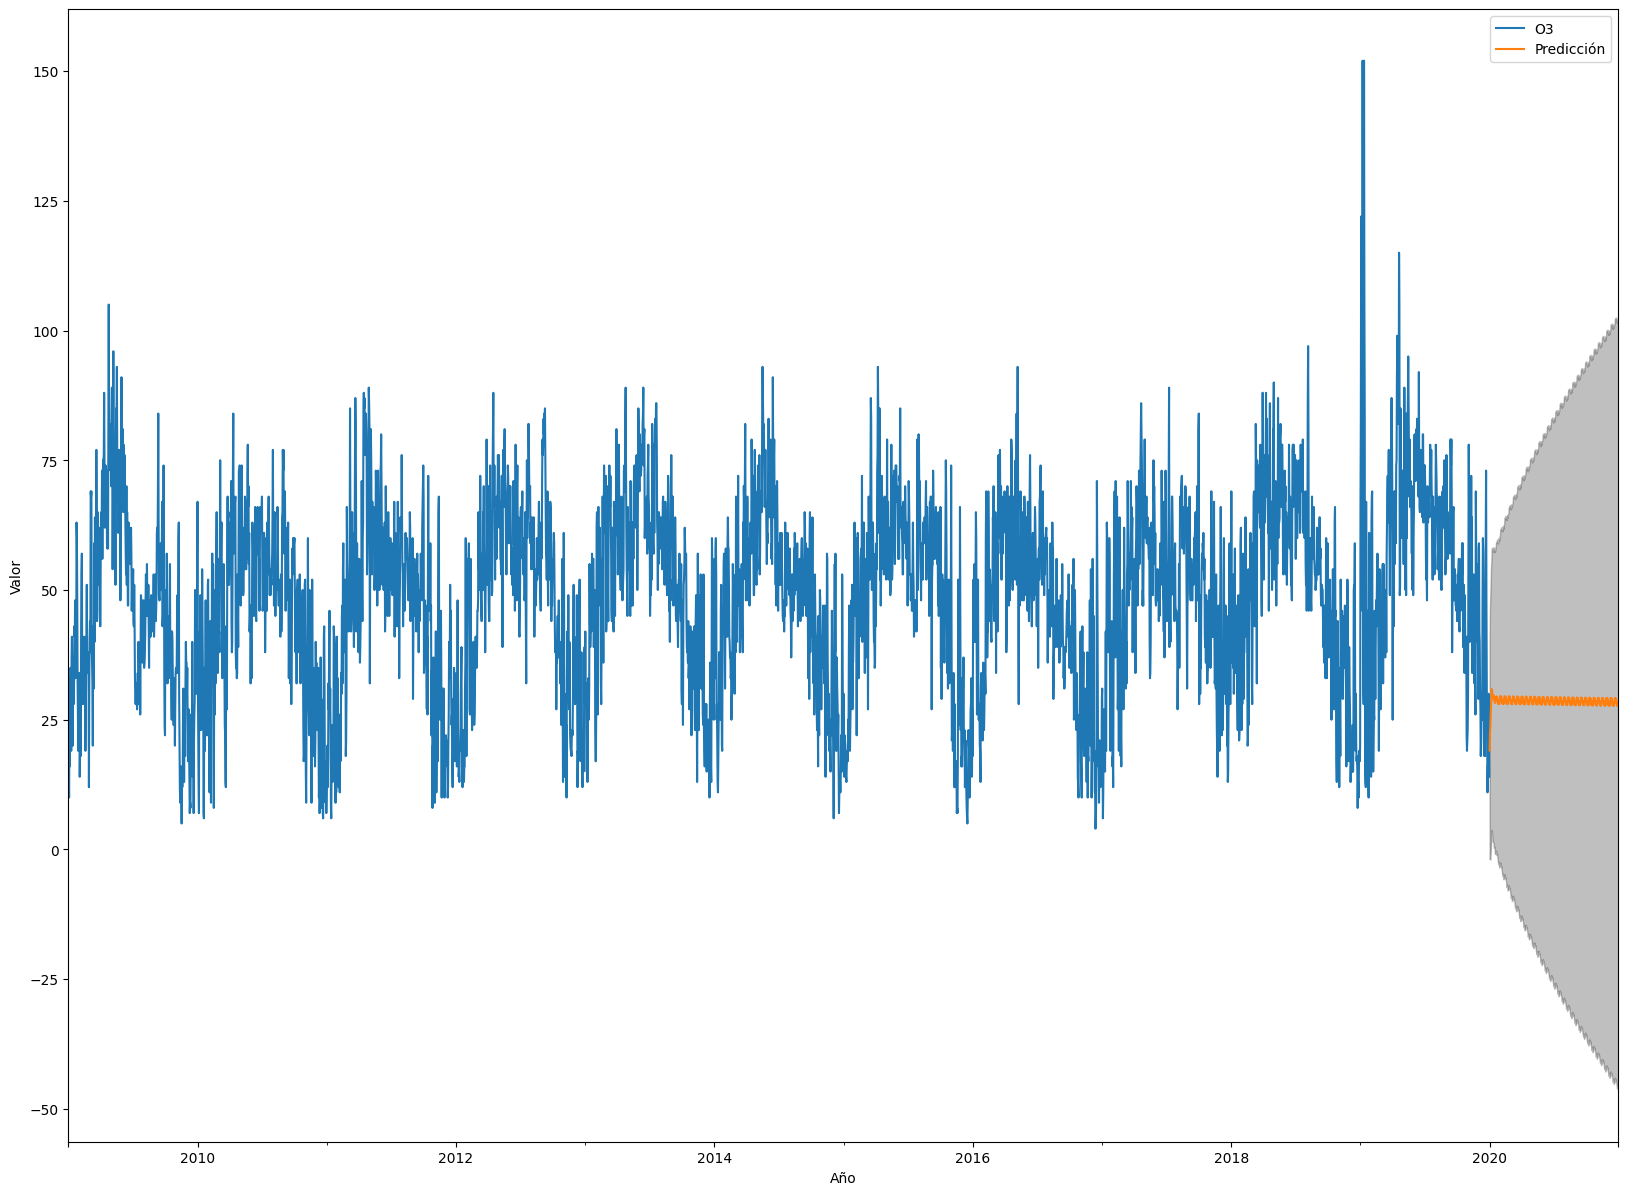

In [44]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=365)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


ax = SerieValMen.plot(label='Real', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Predicción')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Año')
ax.set_ylabel('Valor')

plt.legend()
plt.show()
